In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy

In [2]:
def qPCR_kinetic(n, k1, k2, k3, C):
    return k1 + k2*np.tanh(k3*(n-C))

In [3]:
def calculate_copy_number(length, concentration, volume):
    """
    concentration: ng/ul
    volume: ul
    length: number of base pairs
    """
    mass = concentration * volume * 1e-9 # g
    mass_per_molecule = length * 618 / (6.02214199 * 1e23) # g/molecule
    return mass / mass_per_molecule

In [4]:
def calculate_ct(names, curves):
    """
    calculate ct value based on a 2-state kinetic model
    curves: input list of np.array, each np.array is a SYBR-ROX value for each step
    init_ct_estimate: starting ct of the first curve
    ct_increment: estimated ct increment of each dilution 
    save: if true, save the fitted figure
    """
    fontdict = {'family': 'Times New Roman', 'size': 20}
    ct = []
    C = 5
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(names):
        signal = curves[i]
        k1 = signal[0]
        k2 = signal[-1]-k1
        k3 = 1.5
        popt, pcov = scipy.optimize.curve_fit(qPCR_kinetic, np.arange(signal.size), signal, \
                                    p0=[k1, k2, k3, C], bounds=([-np.inf, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf]), \
                                   method='trf')
        C += 3
        ct.append(popt[3])
        plt.plot(np.arange(signal.size), signal, 'o', label=f'{name}')
        plt.plot(np.arange(signal.size), qPCR_kinetic(np.arange(signal.size), *popt), '-')

    plt.legend()
    plt.xlabel(r"Cycle number", fontdict=fontdict)
    plt.ylabel(r'Fluorescence signal (a. u.)', fontdict=fontdict)
    return ct

In [5]:
def sigmoid(n, F0, DF, k, C12):
    return F0 + DF / (1+np.exp(-(n-C12)/k))

In [6]:
def calculate_ct_by_sigmoid(names, curves):
    """
    calculate ct value based on a 2-state kinetic model
    curves: input list of np.array, each np.array is a SYBR-ROX value for each step
    init_ct_estimate: starting ct of the first curve
    ct_increment: estimated ct increment of each dilution 
    save: if true, save the fitted figure
    """
    fontdict = {'family': 'Times New Roman', 'size': 20}
    ct = []
    k = 1.5
    C12 = 5
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(names):
        signal = curves[i]
        f0 = signal[0]
        df = signal[-1]
        popt, pcov = scipy.optimize.curve_fit(sigmoid, np.arange(signal.size), signal, \
                                    [f0, df, k, C12], \
                                   method='lm')
        C12 += 3
        ct.append((sigmoid(0, *popt)-popt[0])/popt[1])
        plt.plot(np.arange(signal.size), signal, 'o', label=f'{name}')
        plt.plot(np.arange(signal.size), sigmoid(np.arange(signal.size), *popt), '-')

    plt.legend()
    plt.xlabel(r"Cycle number", fontdict=fontdict)
    plt.ylabel(r'Fluorescence signal (a. u.)', fontdict=fontdict)
    return ct

In [7]:
def calculate_standard_curve(copy_number, ct, save=False):
    fontdict = {'family': 'Times New Roman', 'size': 20}
    plt.figure(figsize=(10, 8))
    sns.regplot(x=np.log(copy_number), y=np.array(ct))
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x = np.log(copy_number), y = ct)
    plt.xlabel(r'Logarithm of copy number', fontdict=fontdict)
    plt.ylabel(r'Threshold $C_T$', fontdict=fontdict)
    if save:
        plt.savefig('standard_fit.tif', dpi=600)
    return slope, intercept, rvalue, pvalue, stderr

In [8]:
data = pd.read_excel("./20220517_ACT1.xls", header=7)
std_name_list = [i+'2' for i in 'CDEFG']
sample_name_list = [i+'3' for i in 'ABCD']
std_bps = 1682
std_init_concentration = 0.1032
sample_concentration = 68.4
cycles = 45
num_wells = len(std_name_list)
std = []
for i in std_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    std.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])
    
sample = []
for i in sample_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    sample.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])

std ct are: [2.545580432947532e-07, 1.5255278346168584e-08, 2.9006931692045707e-10, 2.083325899130924e-11, 3.3930381972300383e-12]
Standard curve: slope = 1.2615059073820172, intercept=-30.16906382040533
sample ct are: [0.00014786346810970497, 0.00010324479170651923, 0.0001360944016958353, 0.0001152315616996156]
CNV: mean = 1.8412130497390138, var = 0.041181235813435184


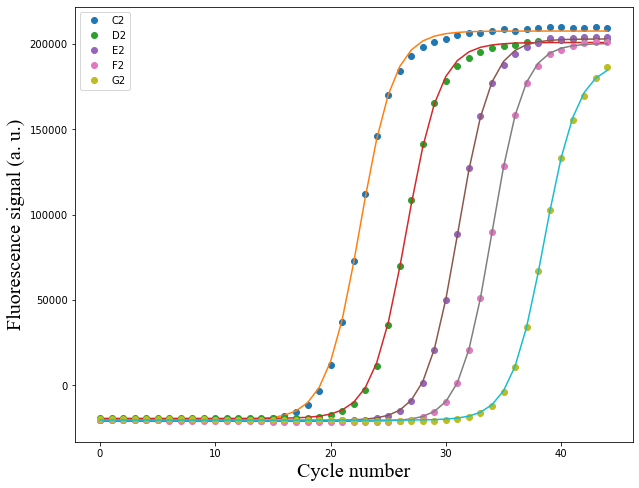

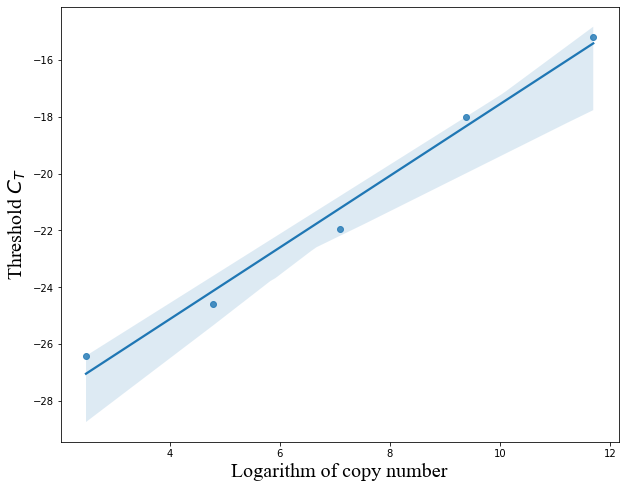

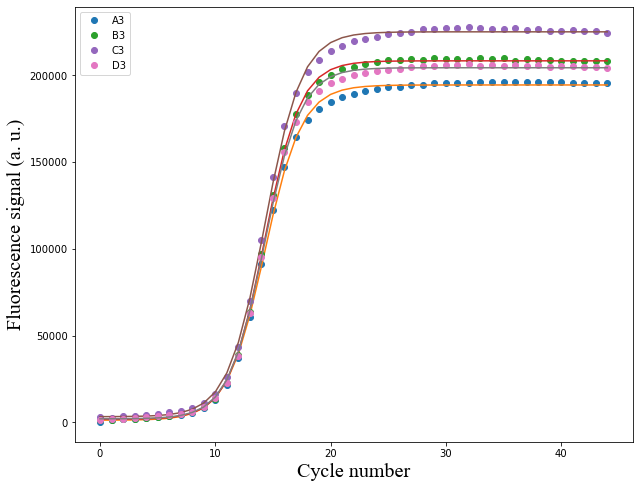

In [9]:
std_ct = calculate_ct_by_sigmoid(std_name_list, std)
print(f'std ct are: {std_ct}')
plt.savefig("fitting_by_sigmoid.tif", dpi=300)

std_n0 = calculate_copy_number(std_bps, std_init_concentration, 2) / 10 ** (np.arange(num_wells)+3)
slope, intercept, rvalue, pvalue, stderr = calculate_standard_curve(std_n0, np.log(std_ct))
print(f'Standard curve: slope = {slope}, intercept={intercept}')
plt.savefig("standard_curve_sigmoid.tif", dpi=300)

sample_ct = calculate_ct_by_sigmoid(sample_name_list, sample)
print(f'sample ct are: {sample_ct}')
plt.savefig("fitting_by_sigmoid_sample.tif", dpi=300)

sample_n0 = np.exp((np.log(sample_ct)-intercept)/slope)
CNV = sample_n0 / calculate_copy_number(12495682, sample_concentration, 2)
print(f'CNV: mean = {np.mean(CNV)}, var = {np.var(CNV)}')

In [10]:
data = pd.read_excel("./20220517_ACT1.xls", header=7)
std_name_list = [i+'2' for i in 'CDEFG']
sample_name_list = [i+'3' for i in 'ABCD']
std_bps = 1682
std_init_concentration = 0.1032
sample_concentration = 68.4
cycles = 45
num_wells = len(std_name_list)
std = []
for i in std_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    std.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])
    
sample = []
for i in sample_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    sample.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])

[22.579264273441357, 26.586095392110884, 31.07917860610811, 34.00430556610797, 38.52612033578159]
Standard curve: slope = -1.7072950927325066, intercept=42.65381173119884
[14.270693361291032, 14.278288383235592, 14.300587225982936, 14.275687384087941]
CNV: mean = 1.5459543985816715, var = 0.00010693887950365602


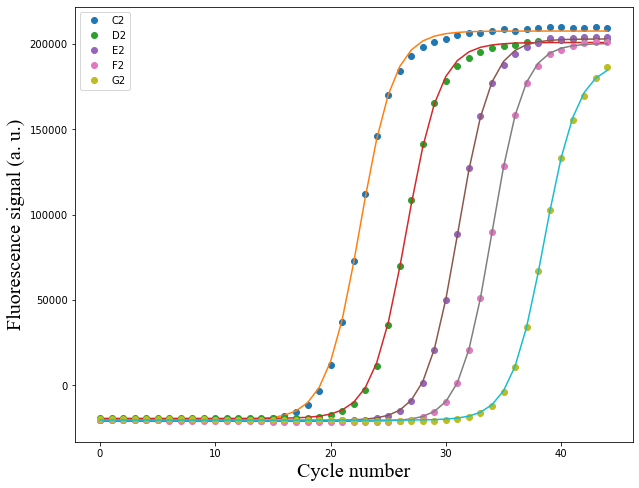

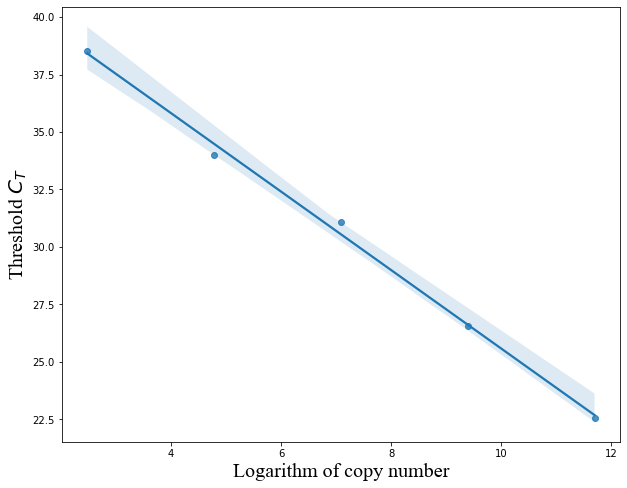

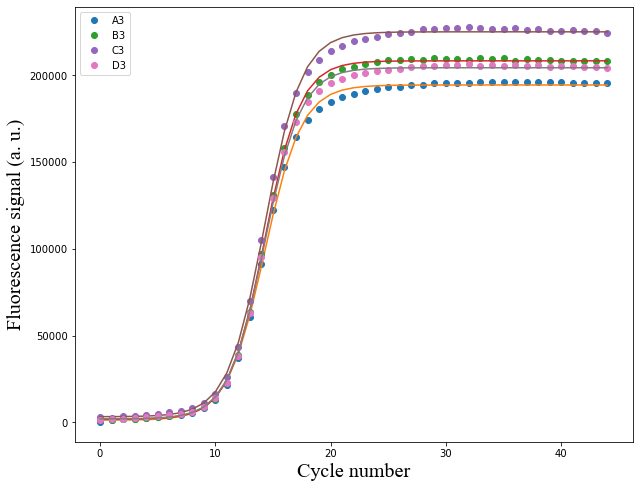

In [11]:
std_ct = calculate_ct(std_name_list, std)
print(std_ct)
plt.savefig("fitting_by_kinetic.tif", dpi=300)

std_n0 = calculate_copy_number(std_bps, std_init_concentration, 2) / 10 ** (np.arange(num_wells)+3)
slope, intercept, rvalue, pvalue, stderr = calculate_standard_curve(std_n0, std_ct)
print(f'Standard curve: slope = {slope}, intercept={intercept}')
plt.savefig("standard_curve_kinetic.tif", dpi=300)

sample_ct = calculate_ct(sample_name_list, sample)
print(sample_ct)
plt.savefig("fitting_by_kinetic_sample.tif", dpi=300)


sample_n0 = np.exp((sample_ct-intercept)/slope)
CNV = sample_n0 / calculate_copy_number(12495682, sample_concentration, 2)
print(f'CNV: mean = {np.mean(CNV)}, var = {np.var(CNV)}')

In [12]:
data = pd.read_excel("./20220517_ACT1.xls", header=7)
std_name_list = [i+'2' for i in 'CDEFG']
sample_name_list = [i+'3' for i in 'ABCD']
std_bps = 1682
std_init_concentration = 0.1032
sample_concentration = 68.4
cycles = 45
num_wells = len(std_name_list)
std = []
for i in std_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    std.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])
    
sample = []
for i in sample_name_list:
    sybr = data["SYBR"][data["Well"] == i].values.astype(float)
    rox = data["ROX"][data["Well"] == i].values.astype(float)
    sample.append(sybr[np.arange(cycles)*3+2] - rox[np.arange(cycles)*3+2])

In [13]:
def gaussian(xi, *param):
    return param[0]*np.exp(-np.power(xi - param[1], 2.) / (2 * np.power(param[2], 2.)))

[21.955169199750753, 25.972819489232972, 30.526477982089983, 33.478829524957504, 37.98910172805327]
Standard curve: slope = -1.7186715580127274, intercept=42.163918283760225
[13.604671429748052, 13.680586677080637, 13.651448458835725, 13.650842124052003]
CNV: mean = 1.506573126214032, var = 0.0005716308240768183


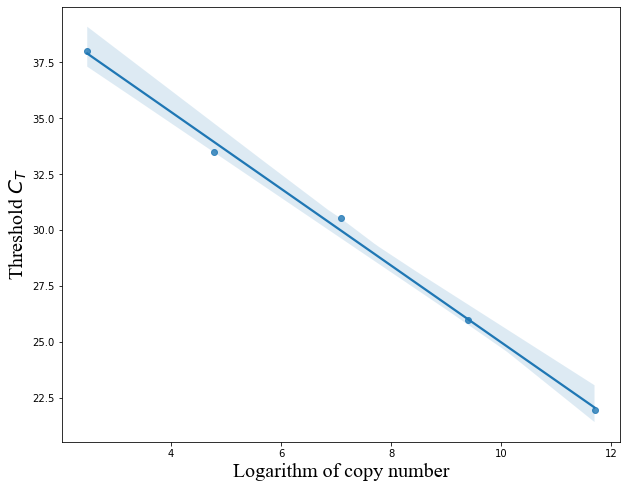

In [14]:
diffs = []
for i in std:
    diffs.append(i[1:]-i[:-1])
diff_ct = []
for i in diffs:
    fit_prop, _ = scipy.optimize.curve_fit(gaussian, np.arange(i.size), i, p0=[0, 20, 10])
    diff_ct.append(fit_prop[1])
print(diff_ct)

std_n0 = calculate_copy_number(std_bps, std_init_concentration, 2) / 10 ** (np.arange(num_wells)+3)
slope, intercept, rvalue, pvalue, stderr = calculate_standard_curve(std_n0, diff_ct)
print(f'Standard curve: slope = {slope}, intercept={intercept}')

diffs = []
for i in sample:
    diffs.append(i[1:]-i[:-1])
sample_diff_ct = []
for i in diffs:
    fit_prop, _ = scipy.optimize.curve_fit(gaussian, np.arange(i.size), i, p0=[0, 20, 10])
    sample_diff_ct.append(fit_prop[1])
print(sample_diff_ct)
sample_n0 = np.exp((np.array(sample_diff_ct)-intercept)/slope)
CNV = sample_n0 / calculate_copy_number(12495682, sample_concentration, 2)
print(f'CNV: mean = {np.mean(CNV)}, var = {np.var(CNV)}')